# Benchmark Model Predicted Results vs Experiments

04/30/2023

Andrew Weng

In [690]:
import os, sys

# Move the path up a level to be able to index into source files
if os.path.basename(os.getcwd()) == 'notebooks':
    os.chdir('../')
    sys.path.insert(0, 'src/')

from src import cellsim as cellsim 

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy.signal import savgol_filter
from src import plotter as plotter

%matplotlib widget
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load the Experimental Data

In [691]:
plotter.initialize(plt)
target_dir = os.getcwd()
target_dir_arbin = f'{target_dir}/data/raw/from-voltaiq'
file_indices_to_include = np.array([1])

cellid = 152064

if cellid == 152064:
    file_arbin_list = [
    f'{target_dir_arbin}/UMBL2022FEB_CELL152064_FORMTAP_2_P45C_5P0PSI_20220901_R1.csv',
    f'{target_dir_arbin}/UMBL2022FEB_CELL152064_FORMBASE_1_P45C_5P0PSI_20220902_R1.csv',
    f'{target_dir_arbin}/UMBL2022FEB_CELL152064_FORMAGING_1_P45C_5P0PSI_20220909_R1.csv',
    f'{target_dir_arbin}/UMBL2022FEB_CELL152064_CYC_1C1CR1_P45C_5P0PSI_20220923_R1.csv'
                    ]

    daq_channel = 'Key_CH1'

    hr_max = 65

elif cellid == 152074: # BASELINE FORMATION (repeat 2)
    
    file_arbin_list = [
    f'{target_dir_arbin}/UMBL2022FEB_CELL152074_FORMTAP_2_P45C_5P0PSI_20220901_R1.csv',
    f'{target_dir_arbin}/UMBL2022FEB_CELL152074_FORMBASE_1_P45C_5P0PSI_20220902_R1.csv',
    f'{target_dir_arbin}/UMBL2022FEB_CELL152074_FORMAGING_1_P45C_5P0PSI_20220909_R1.csv',
                    ]

    daq_channel = 'Key_CH0'

    hr_max = 65

# Load the Arbin Data
df_arbin_list = []

for file in np.array(file_arbin_list)[file_indices_to_include]:

    df = pd.read_csv(file)
    df['Timestamp'] = pd.to_datetime(df['Timestamp'])
    df['Timestamp']= df['Timestamp'].apply(lambda x : x.tz_localize(None))
    df_arbin_list.append(df)

df_arbin = pd.concat(df_arbin_list, axis=0)

# Filter the Arbin Data
ii = df_arbin['Current (A)']
qq = df_arbin['Charge Capacity (Ah)']
tv = df_arbin['Timestamp'].astype(int)
tv = (tv - np.min(tv)) / 1e9
y_voltage = df_arbin['Potential (V)']

y_voltage.iloc[np.where(tv/3600 > hr_max)] = np.NaN

# Load the Keyence data
file_keyence = f'{target_dir}/data/raw/from-keyence/keyence_20220901_213928.csv'
df_keyence = pd.read_csv(file_keyence)
df_keyence['computer time'] = pd.to_datetime(df_keyence['computer time'], unit='s')
df_keyence['computer time'] = df_keyence['computer time'].apply(lambda x : x.tz_localize(None))

# Filter the Keyence data
df_keyence = df_keyence.loc[(df_keyence['computer time'] > df_arbin['Timestamp'].iloc[0]) & \
                            (df_keyence['computer time'] < df_arbin['Timestamp'].iloc[-1])]
y_strain = df_keyence[daq_channel] - df_keyence[daq_channel].iloc[0]
y_strain[y_strain > 500] = np.NaN

tt = df_keyence['computer time'].astype(int)
tt = (tt - np.min(tt)) / 1e9

y_strain.iloc[np.where(tt/3600 > hr_max)] = np.NaN

/var/folders/qr/bx1pzh1x6nnbdrjvw2qhqkf40000gn/T/ipykernel_83518/548818387.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_voltage.iloc[np.where(tv/3600 > hr_max)] = np.NaN


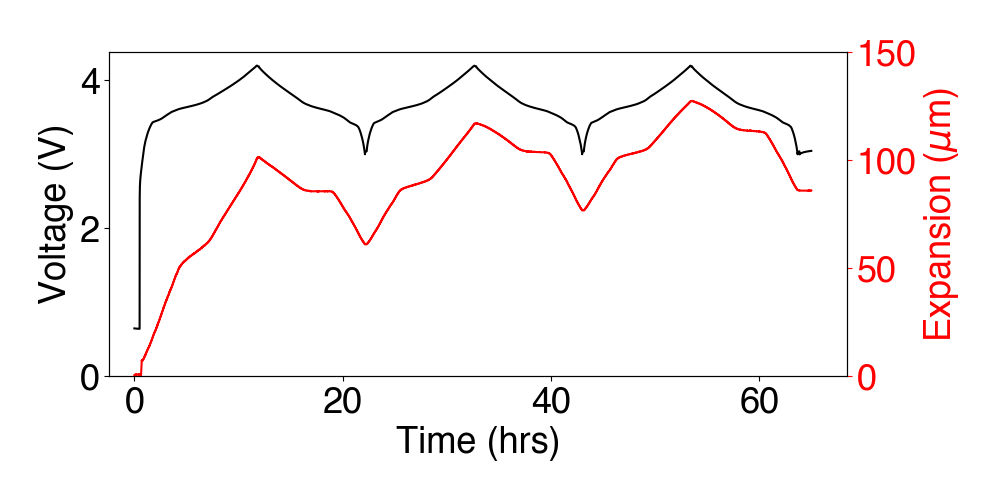

In [692]:
plt.figure(figsize=(10,5))

# The voltage plot
ax1 = plt.subplot()
ax1.plot(tv/3600, y_voltage, color='k')
ax1.set_xlabel('Time (hrs)')
ax1.set_ylabel('Voltage (V)')
ax1.set_ylim(bottom=0)
ax1.grid(False)
ax1.set_xlim((-0.1 * 24, 2.85 * 24))

# The expansion plot
ax2 = ax1.twinx()
ax2.plot(tt/3600, y_strain, color='r')
ax2.set_ylabel(r'Expansion ($\mu$m)')
ax2.tick_params(axis='y', colors='r')
ax2.yaxis.label.set_color('red')
ax2.set_ylim(bottom=0, top=150)
ax2.grid(False)

plt.savefig(f'outputs/figures/fig_strain_vs_voltage_cell{cellid}.png', dpi=300)

# Run the simulation

In [693]:
%autoreload

Q0 = 2.35      # Ah
Ichg = 2.5/10  # A
Idch = -2.5/10 # A
Icv = 2.5/20   # A

vmax = 4.2
vmin = 3.0

cell = cellsim.Cell()
cell.load_config('params/single.yaml')

# Configure the parameters
# cell.k_SEI1  = 4e-20
# cell.D_SEI11 = 5e-17
# cell.D_SEI12 = cell.D_SEI11
# cell.U_SEI1  = 1.9

tag = f'k={cell.k_SEI1}, D={cell.D_SEI11}, U={cell.U_SEI1}, Rn={cell.R0n}, Rp={cell.R0p}'

sim = cellsim.Simulation(cell, 73*3600)

sim.run_rest(1, rest_time_hrs=0.5)
sim.run_chg_cccv(2, Ichg, Icv, vmax)
sim.run_dch_cccv(2, Idch, Idch, vmin)
sim.run_chg_cccv(3, Ichg, Icv, vmax)
sim.run_dch_cccv(3, Idch, Idch, vmin)
sim.run_chg_cccv(4, Ichg, Icv, vmax)
sim.run_dch_cccv(4, Idch, Idch, vmin)
sim.run_rest(5, rest_time_hrs=1)

df_sim = sim.get_results()
df_sim['dq'] = np.abs(df_sim['dt'] * df_sim['i_app'] / 3600)
df_sim['dqsei'] = np.abs(df_sim['dt'] * df_sim['i_sei'] / 3600)

Running Cyc1: Rest for 0.5 hours...
Running Cyc2: Charge to 4.2V...


/Users/aweng/code/formation-modeling/src/cellsim.py:219: RuntimeWarning: divide by zero encountered in double_scalars
  self.j_sei2[k+1] = - 1 / (1/self.j_sei_rxn2[k+1] + 1/self.j_sei_dif2[k+1])


Running Cyc2: Discharge to 3.0V...
Running Cyc3: Charge to 4.2V...
Running Cyc3: Discharge to 3.0V...
Running Cyc4: Charge to 4.2V...
Running Cyc4: Discharge to 3.0V...
Running Cyc5: Rest for 1 hours...


In [694]:
# sim.plot()

# Compare Voltages

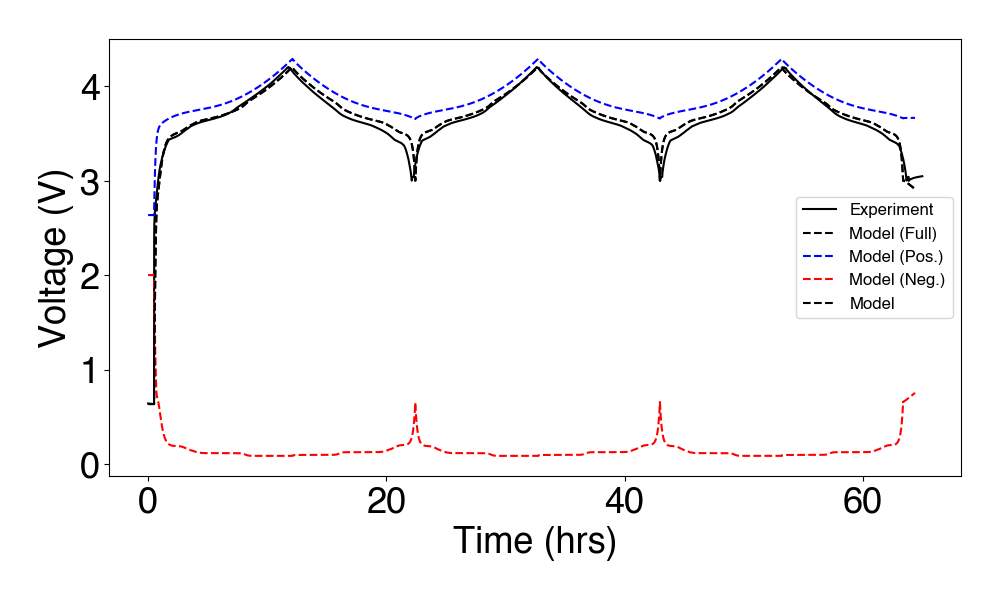

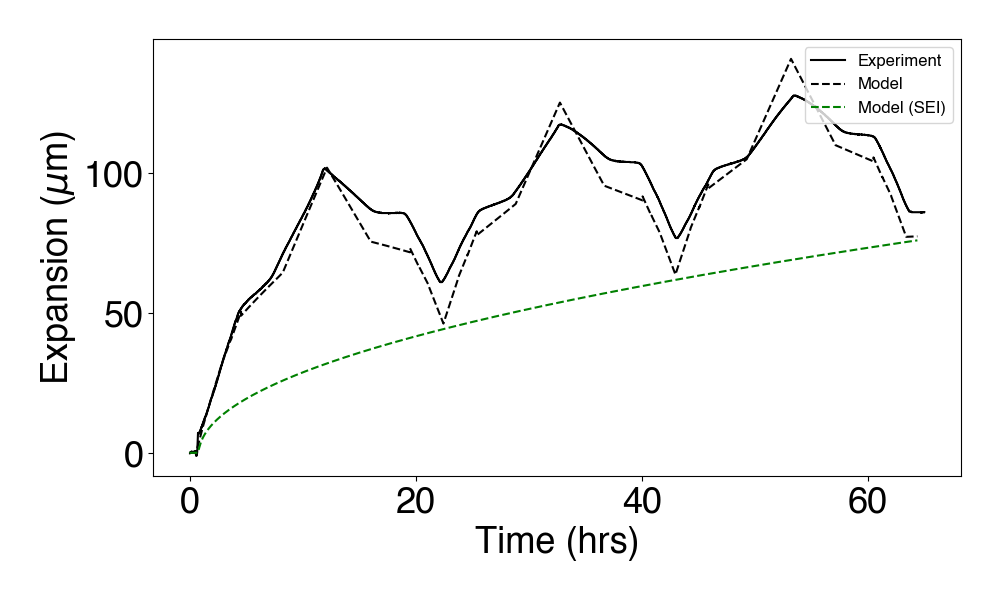

In [695]:
exp_sim = df_sim['expansion_rev'] + df_sim['expansion_irrev']
v_sim = df_sim['vt']
t_sim = df_sim['t']

plt.figure(figsize=(10,6))
plt.grid(False)
plt.plot(tv/3600, y_voltage, c='k', label='Experiment')
plt.plot(t_sim/3600, df_sim['vt'], c='k', ls='--', label='Model (Full)')
plt.plot(t_sim/3600, df_sim['ocv_p'] + df_sim['eta_p'], c='b', ls='--', label='Model (Pos.)')
plt.plot(t_sim/3600, df_sim['ocv_n'] - df_sim['eta_n'], c='r', ls='--', label='Model (Neg.)')
plt.plot(t_sim/3600, df_sim['vt'], c='k', ls='--', label='Model')
plt.legend(loc='right', fontsize=12)
plt.xlabel('Time (hrs)')
plt.ylabel('Voltage (V)')
plt.savefig(f'outputs/figures/fig_v_{tag}.png')

plt.figure(figsize=(10,6))
plt.grid(False)
plt.plot(tt/3600, y_strain, c='k', label='Experiment')
plt.plot(t_sim/3600, (df_sim['expansion_rev'] + df_sim['expansion_irrev'])*1e6, c='k', ls='--', label='Model')
plt.plot(t_sim/3600, (df_sim['expansion_irrev'])*1e6, c='g', ls='--', label='Model (SEI)')
plt.xlabel('Time (hrs)')
plt.ylabel('Expansion ($\mu$m)')
plt.legend(loc='upper right', fontsize=12)
plt.savefig(f'outputs/figures/fig_exp_{tag}.png')

# Compare the dQ/dV during the first and second cycles

/var/folders/qr/bx1pzh1x6nnbdrjvw2qhqkf40000gn/T/ipykernel_83518/2232539571.py:63: RuntimeWarning: divide by zero encountered in divide
  plt.plot(qq1, dv1/dt1, c='r', label='Experiment, Cyc 1')


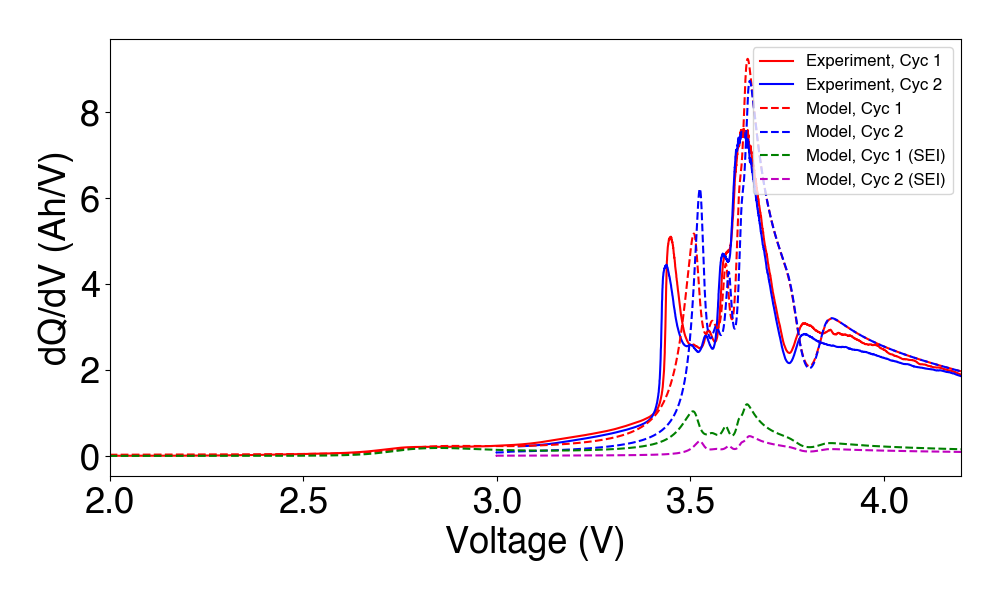

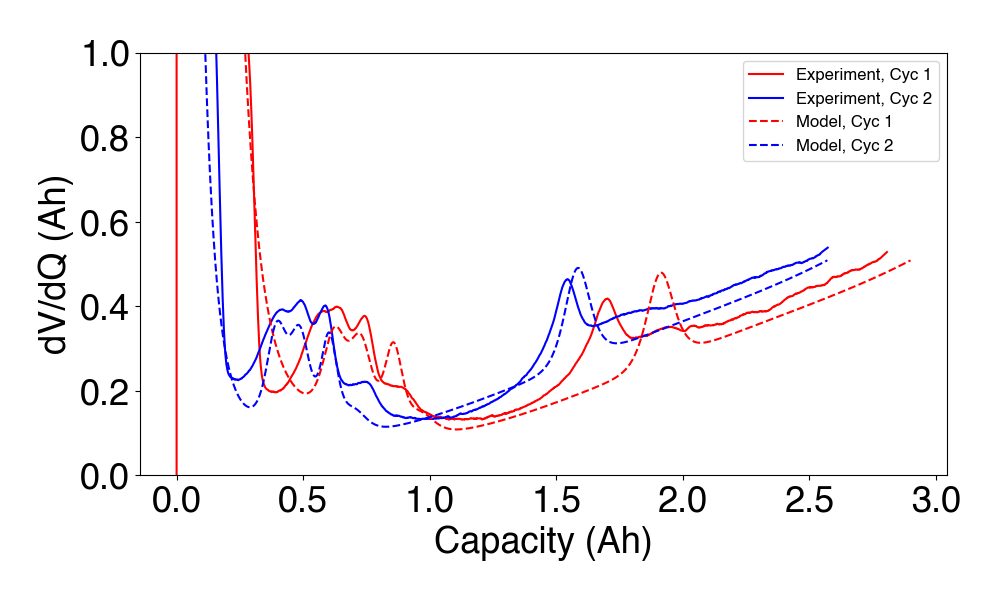

In [696]:

idx = np.where(tv/3600 < 11.74)[0]
qq1 = qq[idx]
vv1 = y_voltage[idx]

idx = np.where((tv/3600 > 22.31) & (tv/3600 < 32.61))[0]
qq2 = qq[idx]
vv2 = y_voltage[idx]

size_factor = 65
window_length = int(len(qq1) / size_factor)
window_length = window_length + 1 if window_length % 2 == 0 else window_length
polyorder = 2

# SG filter on the data to make it smooth
dt1 = savgol_filter(qq1, window_length, polyorder, 1)
dt2 = savgol_filter(qq2, window_length, polyorder, 1)
dv1 = savgol_filter(vv1, window_length, polyorder, 1)
dv2 = savgol_filter(vv2, window_length, polyorder, 1)

# Simulated data

df_sim1 = df_sim[df_sim['cycle_number'] == 2]
df_sim1 = df_sim1[df_sim1['step_number'] == 0]

df_sim2 = df_sim[df_sim['cycle_number'] == 3]
df_sim2 = df_sim2[df_sim2['step_number'] == 0]

qqsim1 = np.cumsum(df_sim1['dq'])
qqsim2 = np.cumsum(df_sim2['dq'])
qssim1 = np.cumsum(df_sim1['dqsei'])
qssim2 = np.cumsum(df_sim2['dqsei'])
vvsim1 = df_sim1['vt']
vvsim2 = df_sim2['vt']

# dQ
dqs1 = savgol_filter(qqsim1, window_length, polyorder, 1)
dqs2 = savgol_filter(qqsim2, window_length, polyorder, 1)

# dQ SEI
dqss1 = savgol_filter(qssim1, window_length, polyorder, 1)
dqss2 = savgol_filter(qssim2, window_length, polyorder, 1)

# dVoltage
dvs1 = savgol_filter(vvsim1, window_length, polyorder, 1)
dvs2 = savgol_filter(vvsim2, window_length, polyorder, 1)

# Make the plot
plt.figure(figsize=(10,6))
plt.plot(vv1, dt1/dv1, c='r', label='Experiment')
# plt.plot(vv2, dt2/dv2, c='b', label='Experiment, Cyc 2')
plt.plot(vvsim1, dqs1/dvs1, c='r', ls='--', label='Model')
# plt.plot(vvsim2, dqs2/dvs2, c='b', ls='--', label='Model, Cyc 2')
plt.plot(vvsim1, dqss1/dvs1, c='g', ls='--', label='Model (SEI)')
# plt.plot(vvsim2, dqss2/dvs2, c='m', ls='--', label='Model, Cyc 2 (SEI)')
plt.xlabel('Voltage (V)')
plt.ylabel('dQ/dV (Ah/V)')
plt.grid(False)
plt.xlim((2, 4.2))
plt.legend(loc='upper right', fontsize=12)
plt.savefig(f'outputs/figures/fig_dqdv_{tag}.png')

plt.figure(figsize=(10,6))
plt.plot(qq1, dv1/dt1, c='r', label='Experiment')
# plt.plot(qq2, dv2/dt2, c='b', label='Experiment, Cyc 2')
plt.plot(qqsim1, dvs1/dqs1, c='r', ls='--', label='Model')
# plt.plot(qqsim2, dvs2/dqs2, c='b', ls='--', label='Model, Cyc 2')
plt.ylim((0, 1))
plt.xlabel('Capacity (Ah)')
plt.ylabel('dV/dQ (Ah)')
plt.grid(False)
plt.legend(loc='upper right', fontsize=12)
plt.savefig(f'outputs/figures/fig_dvdq_{tag}.png')

# Compare coulombic efficiency at each cycle

/var/folders/qr/bx1pzh1x6nnbdrjvw2qhqkf40000gn/T/ipykernel_83518/953515253.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_meas_agg = df_arbin.groupby(['Cycle Number'])['Charge Capacity (Ah)', 'Discharge Capacity (Ah)'].agg('max')


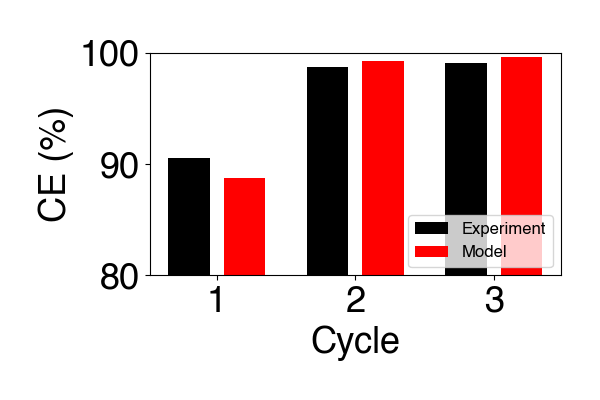

In [697]:
# Measured coulombic efficiency
df_meas_agg = df_arbin.groupby(['Cycle Number'])['Charge Capacity (Ah)', 'Discharge Capacity (Ah)'].agg('max')
df_meas_agg = df_meas_agg.iloc[0:3]
df_meas_agg['ce'] = df_meas_agg['Discharge Capacity (Ah)'] / df_meas_agg['Charge Capacity (Ah)']

# Simulated coulombic efficiency
df_agg = df_sim.groupby(['cycle_number', 'step_number'])['dq'].agg('sum')
ce_sim = []
cycle_index = np.array([2, 3, 4])
for i in cycle_index:
    ce_sim.append(df_agg[i][2] / (df_agg[i][0] + df_agg[i][1]))
ce_sim = np.array(ce_sim)

# Make the plot
plt.figure(figsize=(6, 4))
xx = np.array([1, 2, 3])
plt.bar(xx-0.2, df_meas_agg['ce']*100, color='k', width=0.3, label='Experiment')
plt.bar(xx+0.2, ce_sim*100, color='r', width=0.3, label='Model')

plt.ylabel('CE (%)')
plt.grid(False)
plt.xlabel('Cycle')
plt.legend(loc='lower right', fontsize=12)
plt.ylim([80, 100])
plt.show()
plt.savefig(f'outputs/figures/fig_ce_{tag}.png')


# Stoichiometry Evolution

Text(0, 0.5, '$U_n$')

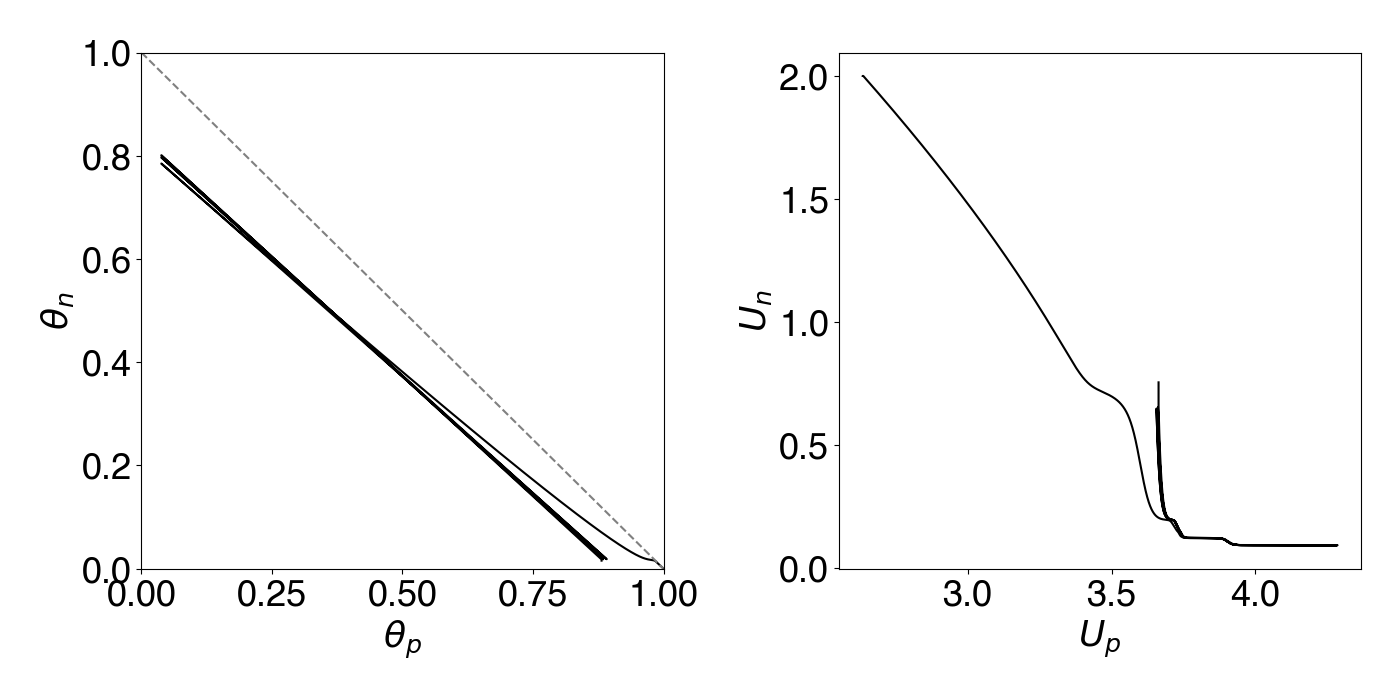

In [698]:

fh, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(14, 7))

xx = np.linspace(0, 1, 100)
ax0.plot(sim.theta_p, sim.theta_n, c='k')
ax0.plot(xx, 1-xx, c=(0.5,0.5,0.5), ls='--')
ax0.set_xlabel(r'$\theta_p$')
ax0.set_ylabel(r'$\theta_n$')
ax0.grid(False)
ax0.set_xlim((0,1))
ax0.set_ylim((0,1))

ax1.plot(sim.ocv_p, sim.ocv_n, c='k')
ax1.grid(False)
ax1.set_xlabel(r'$U_p$')
ax1.set_ylabel(r'$U_n$')